In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import streamlit as st
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose, STL

from typing import Union
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

from itertools import product


import torch
from torchmetrics.regression import MeanAbsoluteError
from torchmetrics import MeanAbsolutePercentageError



np.random.seed(42)

In [2]:
df = pd.read_csv('./data/air-passengers.csv')
df.head(5)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
df.shape

(144, 2)

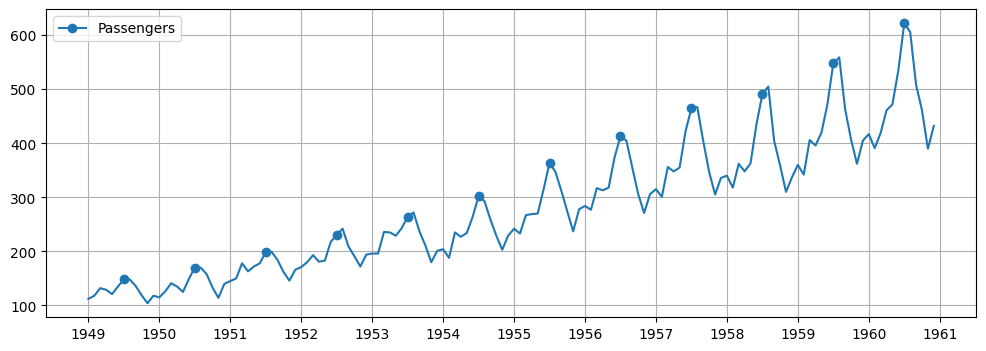

In [4]:
ax = df.plot( markevery=np.arange(6, 145, 12), marker='o', figsize=(12,4))
ax.set_xticks( np.arange(0, 145, 12), np.arange(1949, 1962, 1) )
ax.grid()

plt.show()

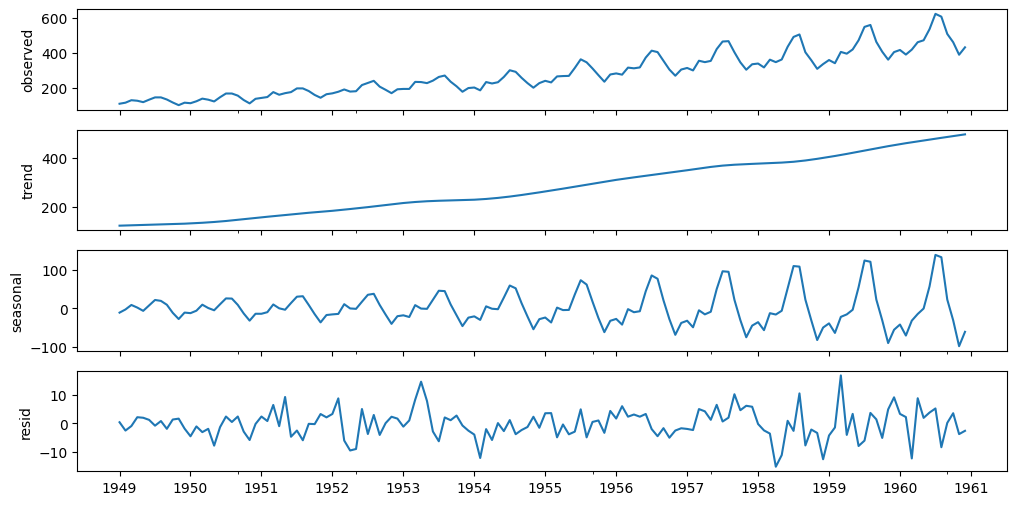

In [8]:
decomposition = STL(df['Passengers'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(12,6))
plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

decomposition.observed.plot(ax=ax1)
decomposition.trend.plot(ax=ax2)
decomposition.seasonal.plot(ax=ax3)
decomposition.resid.plot(ax=ax4)

ax1.set_ylabel('observed')
ax2.set_ylabel('trend')
ax3.set_ylabel('seasonal')
ax4.set_ylabel('resid')

plt.show()

In [7]:
ad_fuller_result = adfuller(df.Passengers)
ad_fuller_result

(0.8153688792060447,
 0.9918802434376409,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [8]:
d = 2

df_diff = np.diff(df['Passengers'], n=d)
ad_fuller_result = adfuller(df_diff)
ad_fuller_result

(-16.38423154246855,
 2.732891850013928e-29,
 11,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 988.6020417275603)

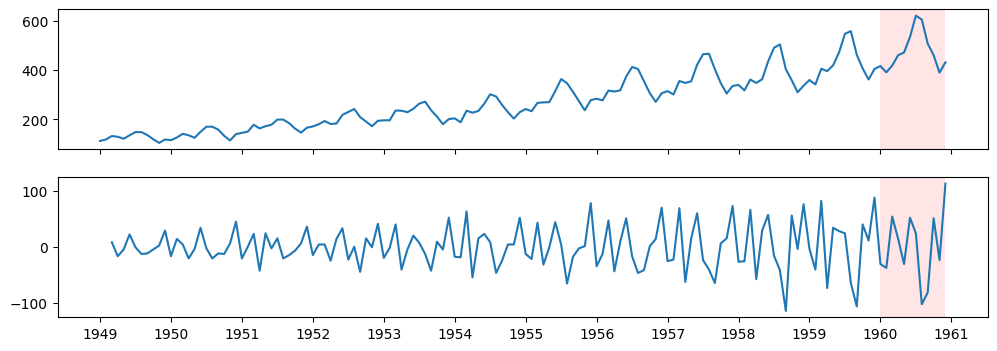

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
ax1.plot(df.Passengers )
ax1.axvspan(132, 143, facecolor='red', alpha=0.1)
ax1.set_xticks( np.arange(0, 145, 12), np.arange(1949, 1962, 1))

a = pd.DataFrame(df_diff)
a.index = a.index + d
ax2.plot(a)
ax2.axvspan(132, 143, facecolor='red', alpha=0.1)

plt.show()

In [10]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, isSeasonal: bool, D = 0, s = 0) -> pd.DataFrame:
    
    results = []

    
    for order in tqdm_notebook(order_list):
        if(isSeasonal == True):
            try: 
                model = SARIMAX(
                    endog, 
                    order=(order[0], d, order[1]),
                    seasonal_order=(order[2], D, order[3], s),
                    simple_differencing=False).fit(disp=False)
            except:
                continue
        else:
            try: 
                model = SARIMAX(
                    endog, 
                    order=(order[0], d, order[1]), 
                    simple_differencing=False).fit(disp=False)
            except:
                continue
            
        aic = model.aic
        results.append([order, aic])



    
    result_df = pd.DataFrame(results)
    
    result_df.columns = ['(p,q,P,Q)', 'AIC'] if isSeasonal else ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [11]:
ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = [0]
Qs = [0]

ARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['Passengers'][:-12]

ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, False)
ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(11, 3, 0, 0)",1016.838772
1,"(11, 4, 0, 0)",1019.018847
2,"(11, 5, 0, 0)",1020.377574
3,"(11, 1, 0, 0)",1021.028121
4,"(12, 0, 0, 0)",1021.231718
...,...,...
164,"(5, 0, 0, 0)",1281.732157
165,"(3, 0, 0, 0)",1300.282335
166,"(2, 0, 0, 0)",1302.913196
167,"(1, 0, 0, 0)",1308.152194


In [12]:
ARIMA_model = SARIMAX(train, order=(11,2,3), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

print(ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  132
Model:              SARIMAX(11, 2, 3)   Log Likelihood                -493.419
Date:                Tue, 13 Aug 2024   AIC                           1016.839
Time:                        17:44:16   BIC                           1059.852
Sample:                             0   HQIC                          1034.316
                                - 132                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8239      0.100     -8.217      0.000      -1.020      -0.627
ar.L2         -0.9630      0.049    -19.750      0.000      -1.059      -0.867
ar.L3         -0.8520      0.087     -9.749      0.0

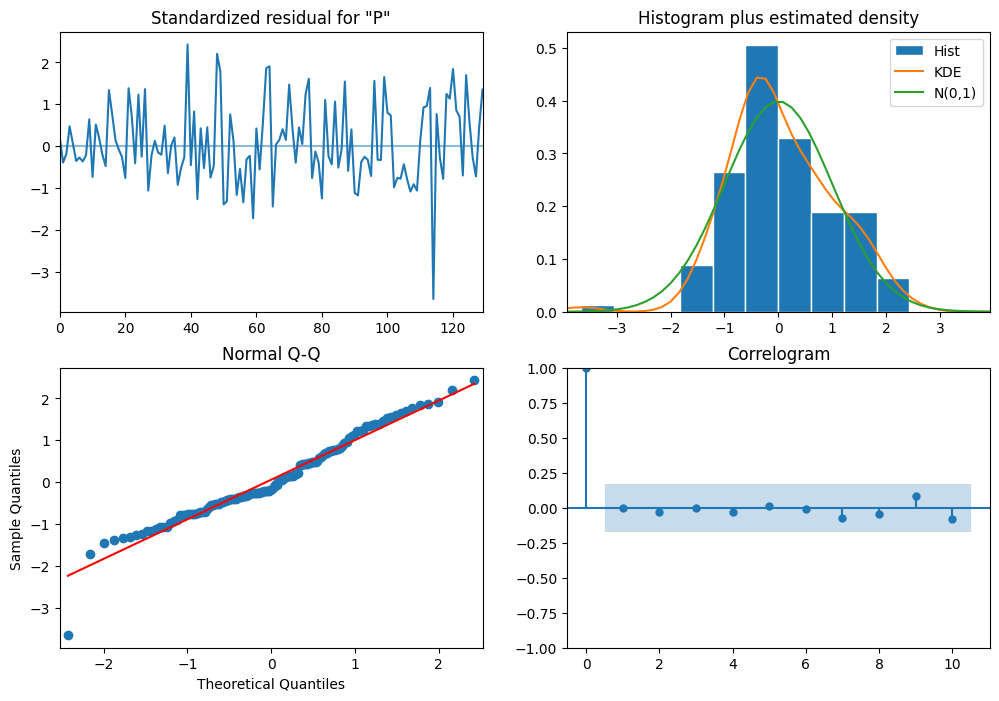

In [13]:
ARIMA_model_fit.plot_diagnostics(figsize=(12,8))
plt.show()

In [14]:
residuals = ARIMA_model_fit.resid
tr = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(tr)

      lb_stat  lb_pvalue
1    6.559480   0.010433
2    6.686835   0.035316
3    6.968832   0.072898
4    7.758945   0.100818
5    8.401991   0.135429
6    8.684766   0.192098
7    9.494035   0.219104
8    9.732594   0.284298
9    9.743174   0.371674
10  11.540823   0.316962


In [15]:
test = df.iloc[-12:]

test['naive_seasonal'] = df['Passengers'].iloc[120:132].values
test['ARIMA_pred'] = ARIMA_model_fit.get_prediction(132, 143).predicted_mean
test

,Month,Passengers,naive_seasonal,ARIMA_pred
132,1960-01,417,360,422.368712
133,1960-02,391,342,410.637667
134,1960-03,419,406,461.827488
135,1960-04,461,396,457.827939
136,1960-05,472,420,481.698510
137,1960-06,535,472,531.108649
138,1960-07,622,548,606.151268
139,1960-08,606,559,615.479569
140,1960-09,508,463,525.628309
141,1960-10,461,407,467.123847


In [16]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)


SARIMA_order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, True, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 1, 1, 2)",892.232482
1,"(2, 1, 2, 1)",893.527182
2,"(2, 1, 1, 3)",894.093579
3,"(1, 0, 1, 2)",894.287516
4,"(0, 1, 1, 2)",894.987878
...,...,...
250,"(0, 0, 2, 0)",906.940147
251,"(3, 2, 0, 3)",907.181875
252,"(0, 0, 3, 2)",907.514319
253,"(0, 0, 3, 0)",908.742583


In [17]:
SARIMA_model = SARIMAX(train, order=(2,1,1), seasonal_order=(1,1,2,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                              Passengers   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -439.116
Date:                                 Tue, 13 Aug 2024   AIC                            892.232
Time:                                         17:54:02   BIC                            911.686
Sample:                                              0   HQIC                           900.132
                                                 - 132                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2665      0.085    -14.945      0.000      -1.433      -1

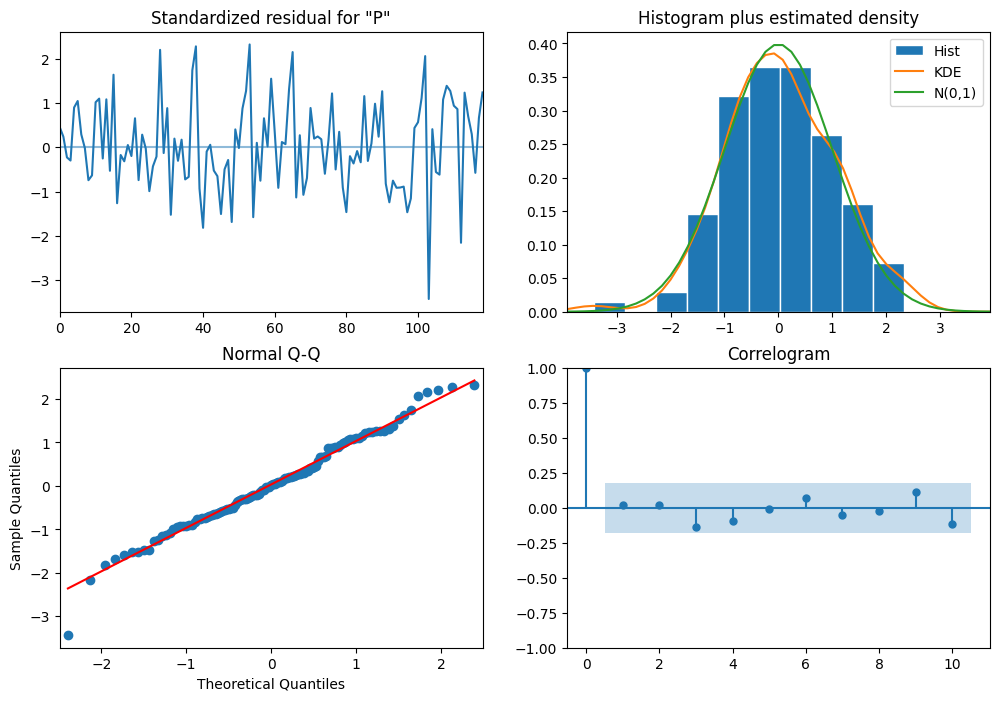

In [18]:
SARIMA_model_fit.plot_diagnostics(figsize=(12,8))
plt.show()

In [19]:
residuals = SARIMA_model_fit.resid
tr = acorr_ljungbox(residuals, np.arange(1, 11, 1))
print(tr)

     lb_stat  lb_pvalue
1   0.004873   0.944347
2   0.745767   0.688746
3   1.022897   0.795712
4   1.227105   0.873616
5   1.436496   0.920280
6   1.712124   0.944181
7   2.308987   0.940781
8   2.719618   0.950703
9   2.736189   0.973843
10  4.969893   0.893180


In [20]:
test['SARIMA_pred'] = SARIMA_model_fit.get_prediction(132, 143).predicted_mean
test

,Month,Passengers,naive_seasonal,ARIMA_pred,SARIMA_pred
132,1960-01,417,360,422.368712,418.513901
133,1960-02,391,342,410.637667,399.577187
134,1960-03,419,406,461.827488,461.313429
135,1960-04,461,396,457.827939,451.452634
136,1960-05,472,420,481.698510,473.744198
137,1960-06,535,472,531.108649,538.788480
138,1960-07,622,548,606.151268,612.440323
139,1960-08,606,559,615.479569,624.594874
140,1960-09,508,463,525.628309,520.173138
141,1960-10,461,407,467.123847,462.852995


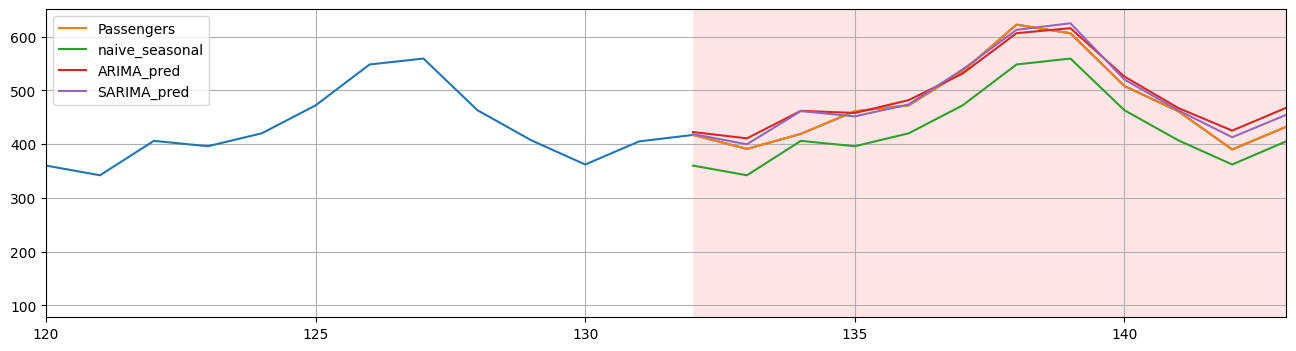

In [35]:
ax = df.Passengers.plot( figsize=(16,4),  layout='constrained' )
ax.axvspan(132, 143, facecolor='red', alpha=0.1)
#ax.set_xticks( np.arange(0, 145, 12), np.arange(1949, 1962, 1))
ax.set_xlim(120, 143)
test.plot( ax = ax)
ax.grid()
plt.show()

In [36]:
mean_absolute_error = MeanAbsoluteError()

maes = {}

pred_naive_seasonal = torch.FloatTensor( test['naive_seasonal'].values)
predict_ARIMA = torch.FloatTensor( test['ARIMA_pred'].values)
predict_SARIMA = torch.FloatTensor( test['SARIMA_pred'].values)
target = torch.FloatTensor(test['Passengers'].values)


maes['mae_naive_seasonal'] =  mean_absolute_error( pred_naive_seasonal, target ).item()
maes['mae_ARIMA'] = mean_absolute_error( predict_ARIMA, target ).item()
maes['mae_SARIMA'] = mean_absolute_error( predict_SARIMA, target ).item()
maes

{'mae_naive_seasonal': 47.83333206176758,
 'mae_ARIMA': 17.0096378326416,
 'mae_SARIMA': 12.886764526367188}

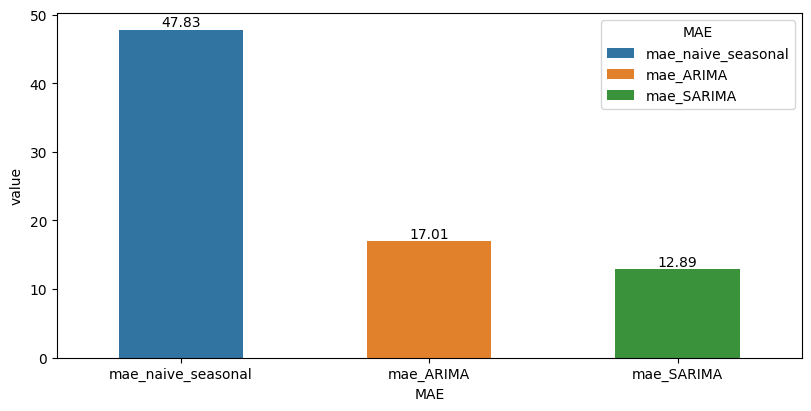

In [38]:
fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
sns.barplot(pd.DataFrame([maes]).melt(), width=0.5, x='variable', y='value', legend=True,  hue= 'variable', ax=ax )

ax.set_xlabel('MAE')
ax.legend(title='MAE')
for index, label in enumerate(maes):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)

In [41]:
mean_abs_percentage_error = MeanAbsolutePercentageError()
mapes = {}

pred_naive_seasonal = torch.FloatTensor( test['naive_seasonal'].values)
predict_ARIMA = torch.FloatTensor( test['ARIMA_pred'].values)
predict_SARIMA = torch.FloatTensor( test['SARIMA_pred'].values)
target = torch.FloatTensor(test['Passengers'].values)

mapes['mape_naive_seasonal'] = mean_abs_percentage_error( pred_naive_seasonal, target).item()
mapes['mape_ARIMA'] = mean_abs_percentage_error( predict_ARIMA, target).item()
mapes['mape_SARIMA'] = mean_abs_percentage_error( predict_SARIMA, target ).item()
mapes

{'mape_naive_seasonal': 0.09987533092498779,
 'mape_ARIMA': 0.03841015323996544,
 'mape_SARIMA': 0.028487682342529297}

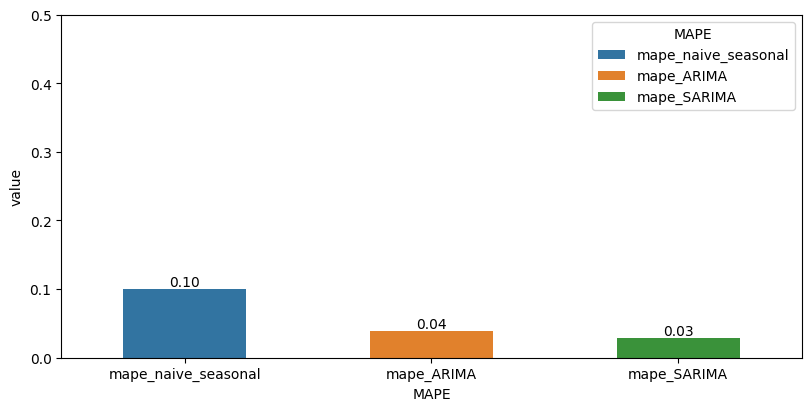

In [42]:
fig, ax = plt.subplots(figsize=(8,4), layout='constrained')
sns.barplot(pd.DataFrame([mapes]).melt(), width=0.5, x='variable', y='value', legend=True,  hue= 'variable', ax=ax )
ax.set_ylim(0, 0.5)
ax.set_xlabel('MAPE')
ax.legend(title='MAPE')
for index, label in enumerate(mapes):   
    ax.bar_label(ax.containers[index], fmt='%.2f',  fontsize=10)